In [1]:
import os 
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.signal as ss
from matplotlib import pyplot
from matplotlib import pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings

In [2]:
df = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/data_with_residual.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,year,fitted,residual
0,2015-12-28,18.827252,48.332993,42.723972,13.288000,111.280,114.305,2015,13.080134,0.207866
1,2016-01-04,15.008106,47.931973,29.411020,12.855000,109.814,112.292,2016,12.971560,-0.116560
2,2016-01-11,15.327347,47.514286,32.301088,12.876667,108.948,111.120,2016,13.031678,-0.155012
3,2016-01-18,15.330000,47.386531,38.159864,13.386667,109.228,111.312,2016,13.099202,0.287464
4,2016-01-25,19.857103,47.281633,40.924449,12.645000,109.566,111.866,2016,12.996417,-0.351417


In [3]:
test = pd.read_csv('C:/Users/ky_moon/Desktop/bigcon/test_data.csv')
test = test.drop('Unnamed: 0', axis=1)
test.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,fitted,residual
0,2020-01-06,26.740816,46.253061,42.972109,16.994000,113.618,111.646,15.433607,1.560393
1,2020-01-13,20.370852,46.189116,43.171588,17.340000,113.978,112.486,15.468105,1.871895
2,2020-01-20,25.564932,46.239796,40.979687,15.586667,113.504,111.910,15.446519,0.140147
3,2020-01-27,18.184592,46.051429,40.331497,16.893333,112.056,110.290,15.242429,1.650904
4,2020-02-03,17.063039,45.943810,40.187143,15.976667,112.180,110.204,14.989041,0.987626


In [4]:
y = df['residual']
X = df[['WIND_SPEED', 'AIR_TEMP', 'Broad']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.75,
                             colsample_bytree=1, max_depth=7)
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
test_residual = xgb_model.predict(test[['WIND_SPEED', 'AIR_TEMP', 'Broad']])

In [17]:
test['residual_predicted'] = test_residual

In [19]:
test.head()

,DATE,WIND_SPEED,SEA_SURF_TEMP,AIR_TEMP,P_PRICE,Broad,Narrow,fitted,residual,residual_predicted
0,2020-01-06,26.740816,46.253061,42.972109,16.994000,113.618,111.646,15.433607,1.560393,1.413984
1,2020-01-13,20.370852,46.189116,43.171588,17.340000,113.978,112.486,15.468105,1.871895,0.614590
2,2020-01-20,25.564932,46.239796,40.979687,15.586667,113.504,111.910,15.446519,0.140147,1.392930
3,2020-01-27,18.184592,46.051429,40.331497,16.893333,112.056,110.290,15.242429,1.650904,0.046787
4,2020-02-03,17.063039,45.943810,40.187143,15.976667,112.180,110.204,14.989041,0.987626,-0.198012


In [20]:
test['predicted_price'] = test['fitted'] + test['residual_predicted']

In [22]:
sse = 0
for i in range(len(test)):
    real = test.iloc[i, :]['P_PRICE']
    pred = test.iloc[i, :]['predicted_price']
    se = (pred - real)**2
    sse += se
mse = sse / test.shape[0]
mse

2.0222402283110332

<AxesSubplot:ylabel='P_PRICE'>

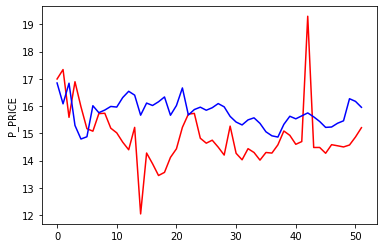

In [23]:
sns.lineplot(data=test['P_PRICE'], color = 'red')
sns.lineplot(data=test['predicted_price'], color = 'blue')